<a href="https://colab.research.google.com/github/ccrivellari/INVEST_IO/blob/master/Tweet_scraping_GetOldtweet3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
#import libraries

!pip install GetOldTweets3
import GetOldTweets3 as got
import importlib
from textblob import TextBlob
import datetime as dt
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

#import google translate API to pass the tweet text and translate it in english.
!pip install googletrans
import googletrans
from googletrans import Translator


# re = python module for regular expression
import re
from datetime import datetime, timedelta

consumer_key = 'Vzk6O5t967f1n4iz9iQcsQwhf'
consumer_secret = 'Q8sncdY1j85mwNitOqb5Spcg6U6uuZ0E2KNHHZEYF2J4DdCyVi'
access_token = '164224789-mFmU5YhessCNvubNojgfL605tbU0vh0NOna3HdQU'
access_secret = 'Ic5LNOH2QqxziSq4eTQdJvbXo3noTcQDUzCKXgFcdPzpC'


# Importing GetOldTweets3

def get_tweets(username, top_only, start_date, end_date, max_tweets):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setUsername(username)\
                          .setTopTweets(top_only)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                          .setMaxTweets(max_tweets)
    
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.date,
                tw.id,
                tw.username,
                tw.permalink,
                tw.text,
                tw.hashtags,
                tw.favorites,
                tw.geo,
                tw.retweets,
                tw.mentions] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    news_df = pd.DataFrame(text_tweets, 
                            columns = ['created_at', 'id', 'user', 'url', 'text', 'hashtags', 'favorite_count', 'location', 'retweet', 'user_mentions'])
    
    return news_df

#2 SENTIMENT ANALYSIS
# # # # TWITTER STREAM LISTENER - Analyzer # # # #
# we can use TextBlob for tweet sentiment analysis and determine the polarity of tweet, from -3 to 3;
# -3 = negative, 0 = neutral, 3 = positive
 
class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    # claen_tweet using the re module to clean tweets text 
    def clean_tweet(self, text):
        return str(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()))
    def translator(self, text):
        translator = Translator()
        translated_tweet = str(translator.translate(text))
    def analyze_sentiment(self, text):
        analysis = TextBlob(self.clean_tweet(text))
        
        if analysis.sentiment.polarity > 0:
            return 3
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -3
   

In [99]:
# Defining news sources I want to include
news_sources = "$AAPL"

# news_sources = ['$AAPL', '$AMZN', '$MSFT', '$GOOGL', '$FB', '$BABA', '$0700', '$BRK', '$V', '$WMT', '$JNJ', '$TSM', '$TSLA', '$PG']
# getting tweets from the defined new sources, 
# only including top tweets, 
# looking at the past week with the end_date not inclusive,
# and specifying that we want a max number of tweets = 100.
# also sorting the tweets by date, descending.

initial_date = "2020-01-01"
final_date = "2020-09-15"
max_tweet = 10000  #per keyword

news_df = get_tweets(news_sources, top_only = True, start_date = initial_date, end_date = final_date, max_tweets = max_tweet).sort_values('created_at', ascending=False)


# getting the tweet full text 
pd.set_option("display.max_colwidth", -1)

# adding the new items 'date' and 'ticker'
ticker = str(news_sources)

news_df["date"] = news_df["created_at"].dt.strftime("%Y-%m-%d")
news_df["ticker"] = f'{news_sources.replace("$", "")}'

# call the class TweetAnalyzer before fill in the column 'sentiment'
tweet_analyzer = TweetAnalyzer()

# ETL on tweets: cleaning, translate, sentiment analysis:

translator = Translator()
news_df['cleaned_text'] = np.array([tweet_analyzer.clean_tweet(text) for text in news_df['text']])
news_df['translated_text'] = np.array([translator.translate(text) for text in news_df['cleaned_text']])

#text language detection

news_df['dect_lan'] = np.array([translator.detect(text) for text in news_df['cleaned_text']])
news_df['dect_lan'] = str(news_df['dect_lan'])[19:21].upper()

#sentiment analysis

polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

news_df['polarity'] = news_df['text'].astype(str).apply(polarity)
news_df['subjectivity'] = news_df['text'].astype(str).apply(subjectivity)

tweet_analyzer = TweetAnalyzer()

news_df['sentiment_analysis'] = np.array([tweet_analyzer.analyze_sentiment(text) for text in news_df['text']])

#salvataggio file csv con stringa del TS convertito in data

news_df = news_df[['date', 'ticker', 'user', 'url', 'created_at', 'id', 'text', 'hashtags', 'translated_text', 'dect_lan', 'favorite_count', 'location', 'retweet', 'user_mentions', 'polarity', 'subjectivity', 'sentiment_analysis']]
#news_df = news_df[['date', 'ticker', 'user', 'link', 'created_at', 'id', 'text', 'hashtags', 'favorite_count', 'location', 'retweet', 'user_mentions', 'polarity', 'subjectivity', 'sentiment_analysis']]

news_df.to_csv(f'tweet_{initial_date.replace("-", "")}' + "_" + f'{final_date.replace("-", "")}' + "_" +  f'{news_sources.replace("$" , "")}' + ".csv", index= False)
#files.download(f'tweet_{initial_date.replace("-", "")}' + "_" + f'{final_date.replace("-", "")}' + "_" +  f'{news_sources.replace("$" , "")}' + ".csv")
news_df.head(100)

An error occured during an HTTP request: HTTP Error 404: Not Found
Try to open in browser: https://twitter.com/search?q=%20from%3A%24aapl%20since%3A2020-01-01%20until%3A2020-09-15&src=typd


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


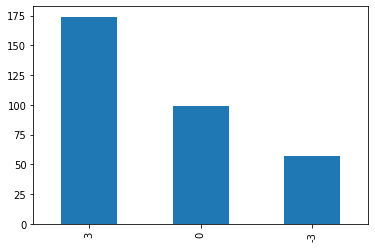

In [91]:
# Plotting

news_df['sentiment_analysis'].value_counts().plot(kind = 'bar')
plt.show()

In [96]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

#Create the wordcloud with the text created above
wordcloud = WordCloud().generate(text)

#Plot the text with the lines below
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: ignored

In [97]:
df_news['sentiment_analysis']

NameError: ignored